# Severity Modeling in Health Insurance Claims (Simulation)

## Project Objective
To analyze and model the claim amounts associated with major medical expenses using severity distributions to understand loss behavior and evaluate the impact of different deductible and coinsurance levels.

In [7]:
import pandas as pd
import scipy.stats 
import matplotlib
import seaborn as sns
import statsmodels

## Data Simulation

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew, mode, lognorm, gamma, weibull_min, expon, kstest

In [3]:
# Set seed for reproductibility
np.random.seed(42)

# Simulate synthetic dataset
n = 5000 # number of claims

# Patient ages between 18 and 80
ages = np.random.randint(18, 81, size=n)

# Treatment types (categorical) 
treatment_types = np.random.choice(['Surgery', 'Hospitalization', 'Outpatient', 'Emergency'], size=n, p=[0.3, 0.4, 0.2, 0.1]) # assigns probabilities to every treatment

# Regions 
regions = np.random.choice(['North', 'South', 'East', 'West'], size=n)

# Claim amounts simulated from a lognormal distribution (right-skewed)
claim_amounts = np.random.lognormal(mean=9, sigma=0.8, size=n)

# Deductible (fixed per patient for now)
deductibles = np.random.choice([500, 1000, 2000], size=n, p=[0.4, 0.4, 0.2])

# Coinsurance (percentage the insurer covers)
coinsurance_rates = np.random.choice([0.7, 0.8, 0.9], size=n)

# Net amount paid by the insurer (after deducible and coinsurance)
net_payments = np.maximum(claim_amounts - deductibles, 0) * coinsurance_rates

# DataFrame
data = pd.DataFrame({
    'Age': ages,
    'Treatment': treatment_types,
    'Region': regions,
    'ClaimAmount': claim_amounts,
    'Deductible': deductibles,
    'Coinsurance': coinsurance_rates,
    'NetPayment': net_payments
})

# Preview the dataset
print(data.head())

   Age   Treatment Region   ClaimAmount  Deductible  Coinsurance    NetPayment
0   56   Emergency  North   8488.984186        1000          0.8   5991.187349
1   69  Outpatient  North  19682.608965         500          0.9  17264.348069
2   46  Outpatient  North  16771.911614         500          0.8  13017.529291
3   32  Outpatient  North   2480.670970        1000          0.9   1332.603873
4   60  Outpatient  North   3579.975976        1000          0.8   2063.980781


In [18]:
# Save dataset (optional)
data.to_csv("simulated_medical_claims.csv", index=False)

## Exploratory Data Analysis (EDA)

In [5]:
# --- Exploratory Data Analysis ---

# Summary statistics
print("\nSummary Statistics for Claim Amounts:")
print(data['ClaimAmount'].describe())
print("\nMean:", data['ClaimAmount'].mean())
print("Median:", data['ClaimAmount'].median())
print("Mode:", mode(data['ClaimAmount']))
print("Standard Deviation:", data['ClaimAmount'].std())
print("Skewness:", skew(data['ClaimAmount']))
print("Kurtosis:", kurtosis(data['ClaimAmount']))


Summary Statistics for Claim Amounts:
count      5000.000000
mean      11099.137010
std       10289.754203
min         522.886131
25%        4666.973976
50%        8028.104868
75%       13953.242414
max      124852.677785
Name: ClaimAmount, dtype: float64

Mean: 11099.137009774344
Median: 8028.104867711936
Mode: ModeResult(mode=522.8861310661667, count=1)
Standard Deviation: 10289.754202792725
Skewness: 2.9562563607575507
Kurtosis: 14.50426139165424


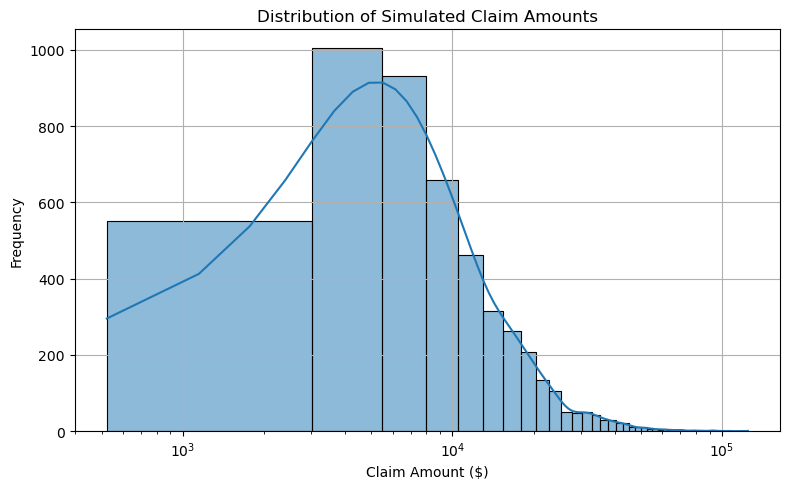

In [7]:
# Plot distribution of claims amounts
plt.figure(figsize=(8,5))
sns.histplot(data['ClaimAmount'], bins=50, kde=True)
plt.title('Distribution of Simulated Claim Amounts')
plt.xlabel('Claim Amount ($)')
plt.ylabel('Frequency')
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

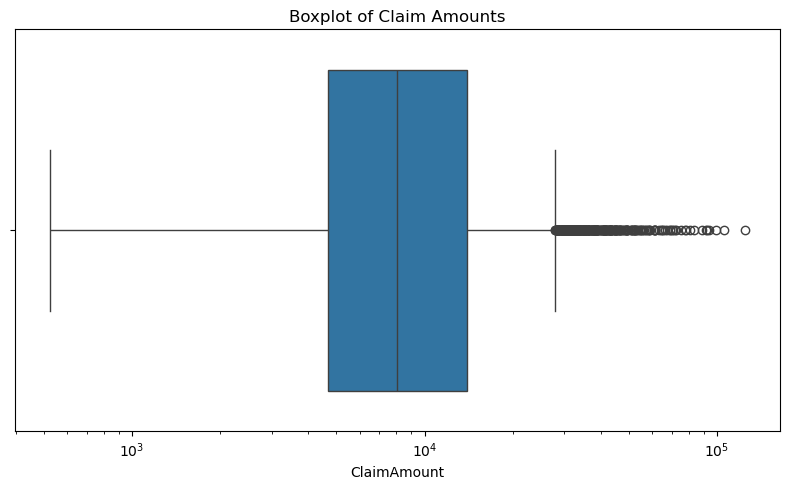

In [9]:
# Boxplot to detect outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['ClaimAmount'])
plt.title('Boxplot of Claim Amounts')
plt.xscale('log')
plt.tight_layout()
plt.show()

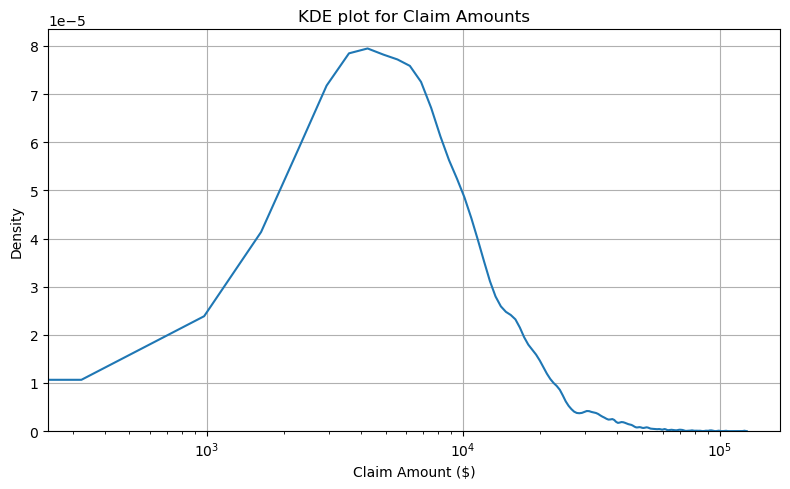

In [11]:
# Density plot (KDE)
plt.figure(figsize=(8,5))
sns.kdeplot(data['ClaimAmount'], bw_adjust=0.5)
plt.title('KDE plot for Claim Amounts')
plt.xlabel('Claim Amount ($)')
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

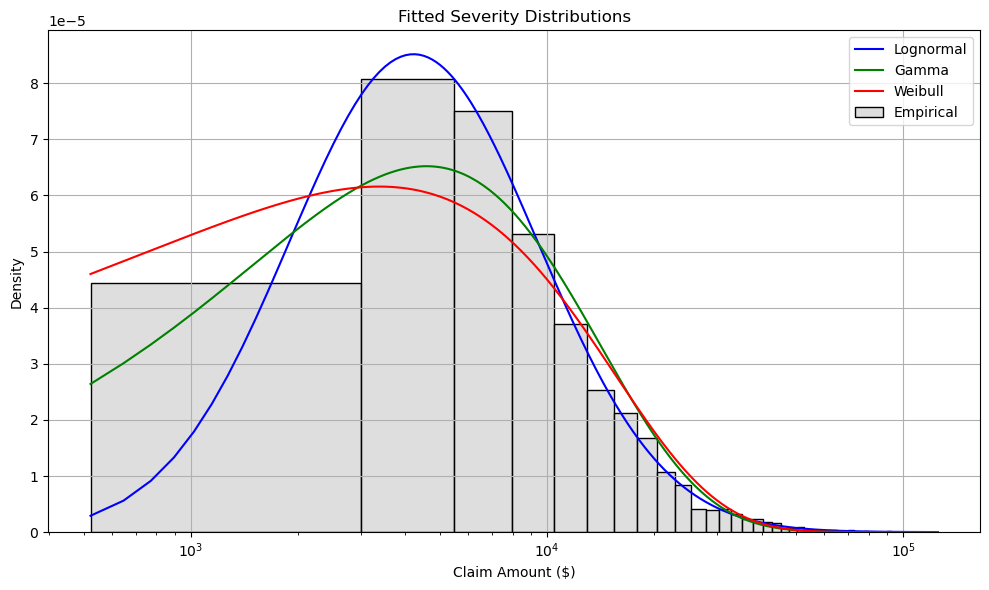

In [17]:
# --- Fit Severity Distributions ---
claim_data = data['ClaimAmount']

# Lognormal Fit
shape_ln, loc_ln, scale_ln = lognorm.fit(claim_data, floc=0)

# Gamma Fit
shape_g, loc_g, scale_g = gamma.fit(claim_data, floc=0)

# Weibull Fit
shape_w, loc_w, scale_w = weibull_min.fit(claim_data, floc=0)

# Compare visually
x = np.linspace(claim_data.min(), claim_data.max(), 1000)

plt.figure(figsize=(10, 6))
sns.histplot(claim_data, bins=50, kde=False, stat='density', label='Empirical', color='lightgray')
plt.plot(x, lognorm.pdf(x, shape_ln, loc_ln, scale_ln), label='Lognormal', color='blue')
plt.plot(x, gamma.pdf(x, shape_g, loc_g, scale_g), label='Gamma', color='green')
plt.plot(x, weibull_min.pdf(x, shape_w, loc_w, scale_w), label='Weibull', color='red')
plt.xscale('log')
plt.xlabel('Claim Amount ($)')
plt.ylabel('Density')
plt.title('Fitted Severity Distributions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# --- Goodness-of-Fit: Kolmogorov-Smirnov Tests ---
dists = {
    'Lognormal': (lognorm, [shape_ln, loc_ln, scale_ln]),
    'Gamma': (gamma, [shape_g, loc_g, scale_g]),
    'Weibull': (weibull_min, [shape_w, loc_w, scale_w])
}

print("\nKolmogorov-Smirnov Test Results:")
for name, (dist, params) in dists.items():
    ks_stat, p_val = kstest(claim_data, dist.name, args=params)
    print(f"{name}: KS Statistic = {ks_stat:.4f}, p-value = {p_val:.4f}")


Kolmogorov-Smirnov Test Results:
Lognormal: KS Statistic = 0.0088, p-value = 0.8350
Gamma: KS Statistic = 0.0590, p-value = 0.0000
Weibull: KS Statistic = 0.0642, p-value = 0.0000


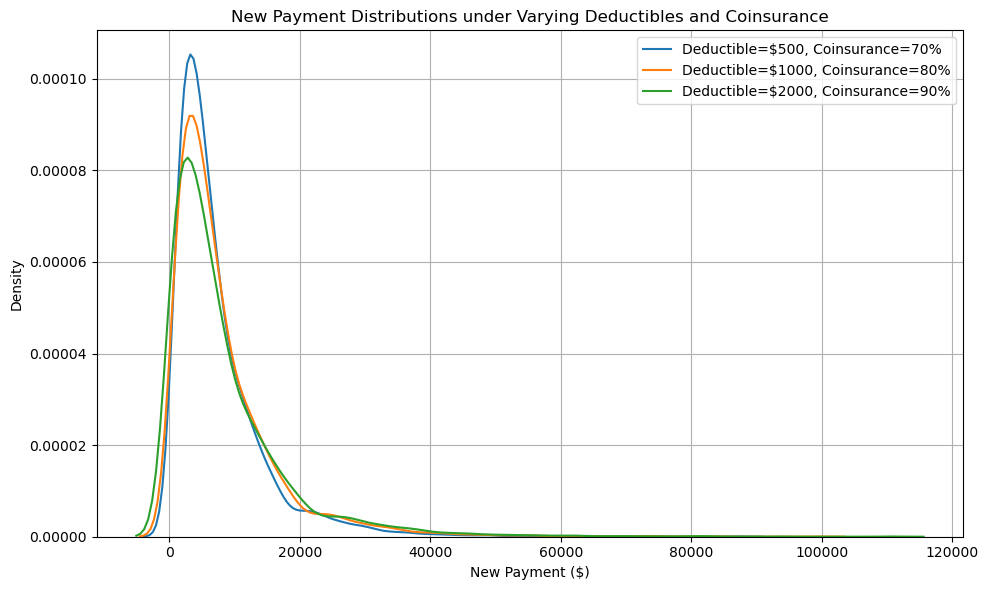

In [27]:
# --- Impact of Deductibles and Coinsurance on Net Payments ---

# Define custom deductible and coinsurance scenarios
scenarios = [
    {"deductible": 500, "coinsurance": 0.7},
    {"deductible": 1000, "coinsurance": 0.8},
    {"deductible": 2000, "coinsurance": 0.9}
]

plt.figure(figsize=(10,6))

for scenario in scenarios:
    d = scenario["deductible"]
    c = scenario["coinsurance"]
    net = np.maximum(claim_data - d, 0) * c
    sns.kdeplot(net, label=f"Deductible=${d}, Coinsurance={int(c*100)}%")

plt.title("New Payment Distributions under Varying Deductibles and Coinsurance")
plt.xlabel("New Payment ($)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

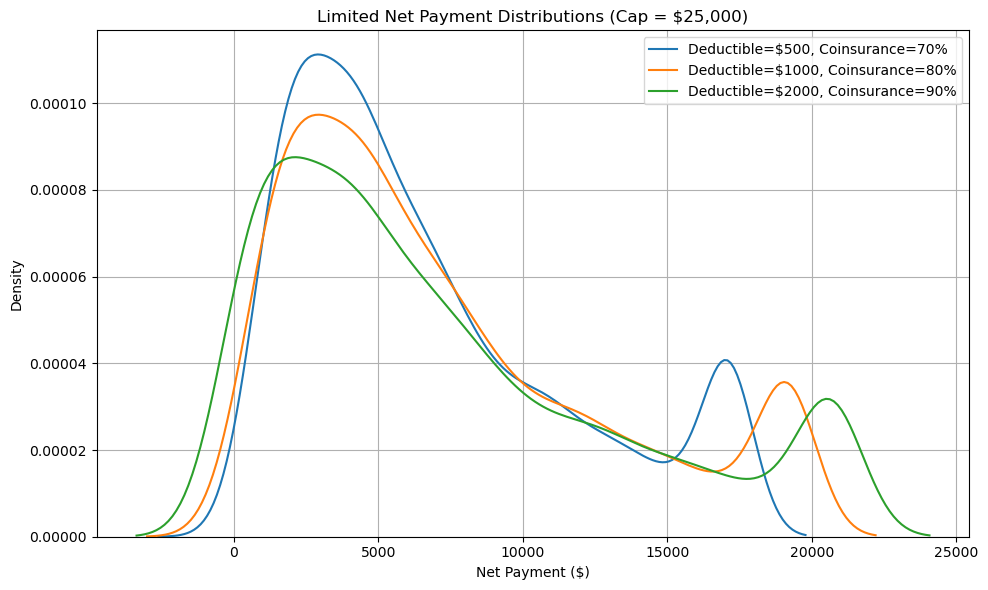

In [33]:
# --- Limited Loss Transformations --- (e.g.applying policy limits)
policy_limit = 25000

plt.figure(figsize=(10, 6))

for scenario in scenarios:
    d = scenario["deductible"]
    c = scenario["coinsurance"]
    gross_loss = np.minimum(claim_data, policy_limit)
    net_loss = np.maximum(gross_loss - d, 0) * c
    sns.kdeplot(net_loss, label=f"Deductible=${d}, Coinsurance={int(c*100)}%")

plt.title("Limited Net Payment Distributions (Cap = $25,000)")
plt.xlabel("Net Payment ($)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [45]:
# --- Risk Measures: Expected Value, Percentiles, VaR, TVaR ---

risk_summary = []

def risk_metrics(loss_array):
    expected = np.mean(loss_array)
    p90 = np.percentile(loss_array, 90)
    p99 = np.percentile(loss_array, 99)
    var_95 = p95 = np.percentile(loss_array, 95)
    tvar_95 = loss_array[loss_array >= var_95].mean()
    return expected, p90, p99, var_95, tvar_95

print("\nRisk Metrics by Scenario:")

for scenario in scenarios:
    d = scenario["deductible"]
    c = scenario["coinsurance"]
    gross_loss = np.minimum(claim_data, policy_limit)
    net_loss = np.maximum(gross_loss - d, 0) * c
    ev, p90, p99, var95, tvar95, = risk_metrics(net_loss)
    risk_summary.append({
        "Deductible": d,
        "Coinsurance": c,
        "Expected": ev,
        "P90": p90,
        "P99": p99,
        "VaR95": var95,
        "TVaR95": tvar95
    })
    print(f"\nDeductible=${d}, Coinsurance={int(c*100)}%")
    print(f" Expected Net Payment: ${ev:,.2f}")
    print(f" 90th Percentile: ${p90:,.2f}")
    print(f" 99th Percentile: ${p99:,.2f}")
    print(f" VaR(95%): ${var95:,.2f}")
    print(f" TVaR(95%): ${tvar95:,.2f}")   


Risk Metrics by Scenario:

Deductible=$500, Coinsurance=70%
 Expected Net Payment: $6,698.80
 90th Percentile: $15,198.41
 99th Percentile: $17,150.00
 VaR(95%): $17,150.00
 TVaR(95%): $17,150.00

Deductible=$1000, Coinsurance=80%
 Expected Net Payment: $7,256.28
 90th Percentile: $16,969.61
 99th Percentile: $19,200.00
 VaR(95%): $19,200.00
 TVaR(95%): $19,200.00

Deductible=$2000, Coinsurance=90%
 Expected Net Payment: $7,281.02
 90th Percentile: $18,190.81
 99th Percentile: $20,700.00
 VaR(95%): $20,700.00
 TVaR(95%): $20,700.00


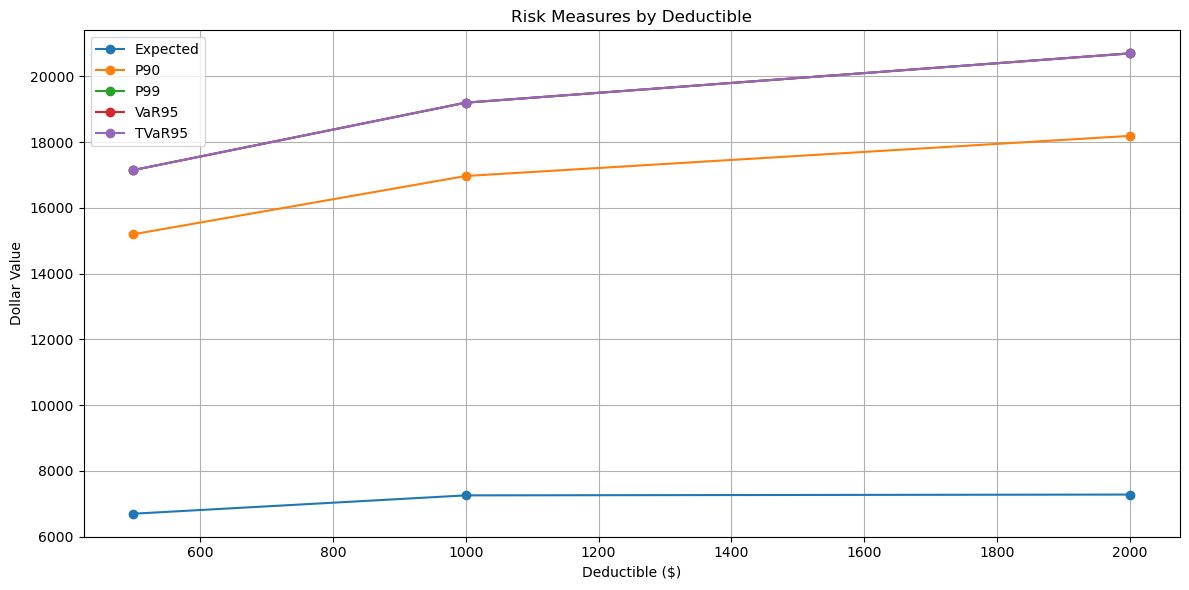

In [47]:
# --- Visualize Risk Measures ---
risk_df = pd.DataFrame(risk_summary)

metrics = ["Expected", "P90", "P99", "VaR95", "TVaR95"]

plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(risk_df['Deductible'], risk_df[metric], marker='o', label=metric)

plt.title("Risk Measures by Deductible")
plt.xlabel("Deductible ($)")
plt.ylabel("Dollar Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()